# AAPL Stock Data Analysis

## Fetching data 

Here I import relevant packages, and fetch AAPL stock data from "2010-01-01" to "2025-01-01", using free data pipeline offered by [yfinance](https://pypi.org/project/yfinance/)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fetch_stock_data(ticker, start_date, end_date):
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

apple_data = fetch_stock_data("AAPL", "2010-01-01", "2025-01-01")
print(apple_data.shape)
apple_data.head()

Fetching data for AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(3774, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431895,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409056,6.449630,601904800
2010-01-06,6.340533,6.468564,6.333921,6.443018,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370885,6.371486,6.283127,6.320394,447610800


We can see that 15 years of data has been fetched, and we have 3774 days of data, corresponding to every working day from 1/1/2010 to 1/1/2025. Every day we have the open, close, high and low stock price of AAPL, as well as the trading volume.

## Exploratory Data Analysis

We begin by plotting the close price for exploratory data analysis. Since the open, high and low are very close to the close price, it doesn't make sense to plot them separately, so we stick to the close price now.

<Axes: title={'center': 'AAPL Stock Close Price'}, xlabel='Date'>

<Figure size 500x300 with 0 Axes>

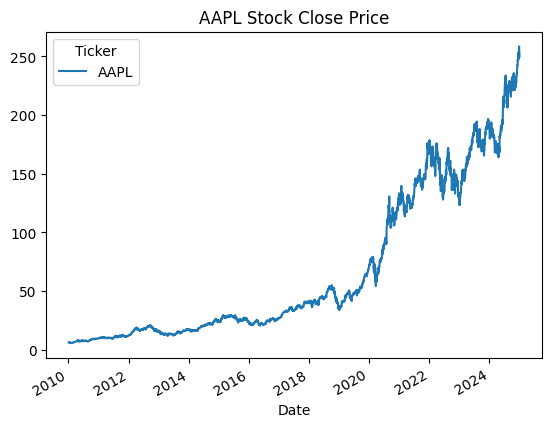

In [2]:
plt.figure(figsize=(5, 3))
apple_data["Close"].plot(title="AAPL Stock Close Price")

<Axes: title={'center': 'AAPL Stock Volume'}, xlabel='Date'>

<Figure size 500x300 with 0 Axes>

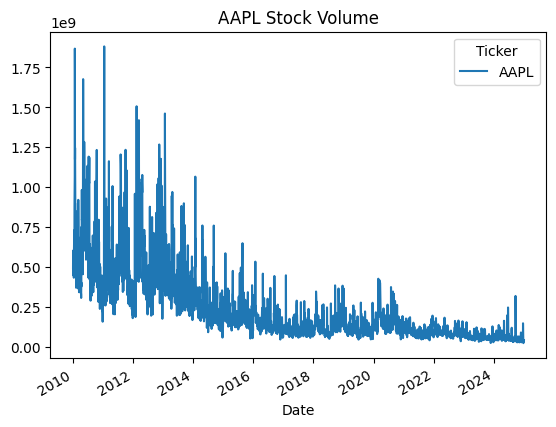

In [3]:
plt.figure(figsize=(5, 3))
apple_data["Volume"].plot(title="AAPL Stock Volume")

We also plot the log returns, given by 

$$
r_t = \log \bigg( \frac{S_t}{S_{t-1}} \bigg)
$$

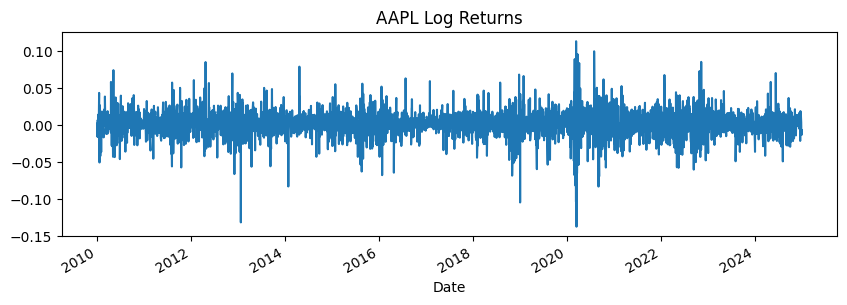

In [4]:
# log returns of AAPL
apple_data['returns'] = apple_data['Close'].pct_change()
apple_data['log_returns'] = np.log(1 + apple_data['returns'])
plt.figure(figsize=(10, 3))
apple_data['log_returns'].plot(title="AAPL Log Returns")
plt.show()

We also want to examine volatility. Now since volatility isn't something directly observed, using just the stock data, there's two ways of looking at volatility.

One way is to simply use absolute value of the log returns, as this is proportional to true volatility. The second way is to use a rolling standard deviation window of past N days. We implement both here:

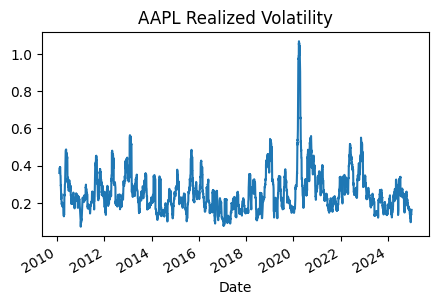

In [5]:
apple_data['realized volatility'] = apple_data['returns'].rolling(window=21).std() * np.sqrt(252) # 252 trading days in a year

plt.figure(figsize=(5, 3))
apple_data['realized volatility'].plot(title="AAPL Realized Volatility")
plt.show()

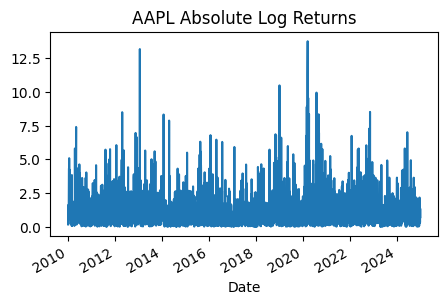

In [6]:
log_returns = apple_data.iloc[1:]['log_returns'] * 100
abs_returns = np.abs(log_returns)
plt.figure(figsize=(5, 3))
abs_returns.plot(title="AAPL Absolute Log Returns")
plt.show()

We can see in both cases, there is a lot of volatility in 2020 during covid era, as the market panicks.

## Statistical Properties Analysis

### Stylised Facts

We quote the four stylized facts of asset returns, which are widely observed empirical regularities in financial time series, especially at high frequencies like daily returns here.

- (SF₁) The unconditional distribution of returns (at a daily or shorter time scale) is markedly non-normal with heavy tails and possibly mild asymmetry.
This means that returns do not follow a Gaussian distribution. Instead, extreme events (large positive or negative returns) are more likely than what a normal distribution would predict. Additionally, the distribution might be slightly skewed.

- (SF₂) Returns are serially uncorrelated.
This implies that past returns do not help predict future returns, which is consistent with the Efficient Market Hypothesis (weak form).

- (SF₃) Volatility is clustered and persistent.
Large changes in returns tend to be followed by large changes (of either sign), and small changes tend to be followed by small changes. This leads to periods of high and low volatility that persist over time.

- (SF₄) Aggregational Gaussianity.
As the time scale increases (e.g., moving from daily to monthly returns), the distribution of returns becomes more Gaussian due to the Central Limit Theorem.

Now we examine if AAPL stock data agrees with those four stylized facts.

### SF1 Non-normality and mild assymetry

We compare the empirical distribution of the log returns of AAPL, as well as its KDE smoother, to a standard normal distribution here. We notice it's non-normal with fatter tails, highlighting higher frequencies of extreme events than a normal distribution would have.

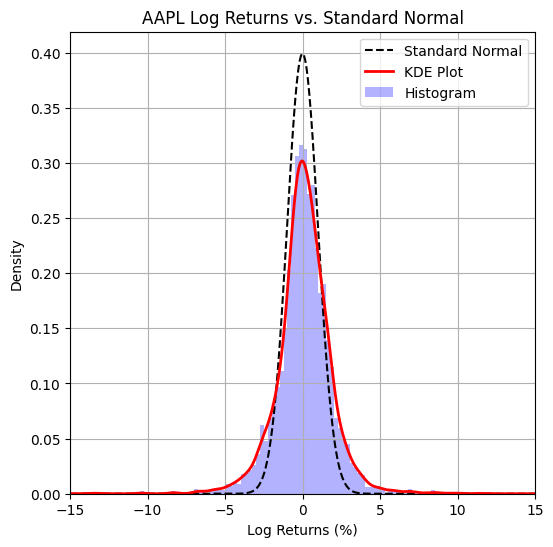

In [7]:
from scipy.stats import norm

x = np.linspace(-15, 15, 1000)
y = norm.pdf(x, 0, 1)  # Standard normal distribution N(0,1)

plt.figure(figsize=(6, 6))
plt.plot(x, y, color='black', linestyle="dashed", label="Standard Normal")

# Pandas KDE plot
# remove first row (NaN), and * 100 to get percentage
log_returns = apple_data.iloc[1:]['log_returns'] * 100
log_returns.plot.kde(color='red', linewidth=2, label="KDE Plot")

# Histogram
plt.hist(log_returns, bins=100, color='blue', alpha=0.3, density=True, label="Histogram")
plt.title("AAPL Log Returns vs. Standard Normal")
plt.xlabel("Log Returns (%)")
plt.xlim(-15, 15)
plt.legend()
plt.grid()
plt.show()

We also use a QQ plot to examine its normality

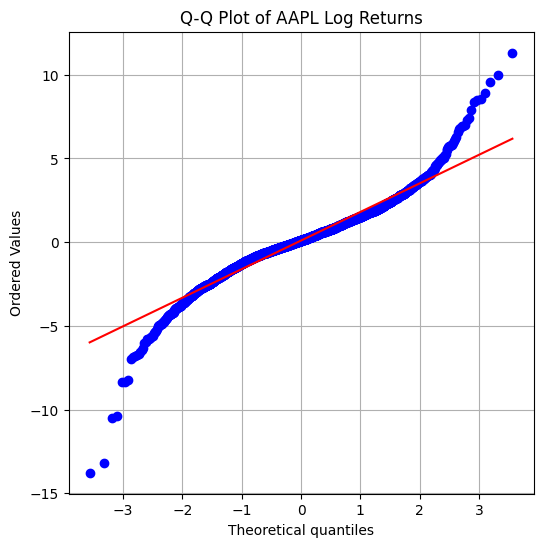

In [8]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot of AAPL Log Returns")
plt.grid()
plt.show()

To examine if it has fatter tails at extremes (whether the distribution converges to 0 at $x \to \pm \infty$ slower than a normal), we examine its kurtosis, and find out it has strong leptokurticity.  
i.e. A normal distribution would have a kurtosis of 3, whereas any distribution with kurtosis larger than 3 is leptokurtic.

In [9]:
# compute sample kurtosis
kurtosis = log_returns.kurtosis()
print(f"Sample kurtosis: {kurtosis}")

Sample kurtosis: 5.45437106688921


### (SF2), no serial correlation 

which is effectively a statement about market efficiency, and related to martingale (independent increment).

We examine this by studying its autocorrelation, given by

$$
\rho_k = \frac{\operatorname{Cov}(r_t, r_{t-k})}{\sqrt{\operatorname{Var}(r_t) \operatorname{Var}(r_{t-k})}} = \operatorname{Corr}(r_t, r_{t-k})
$$

Where $r_t$ is the time series, and $k$ is the lag. A time series that is weakly stationary should have $\operatorname{Corr}(r_t, r_{t-k})$ depend only on $k$ and not $t$.

A serially uncorrelated time series should have autocorr = 1 at $k=0$, and 0 elsewhere, i.e.

$$
\rho_k =
\begin{cases}
1, & \text{if } k = 0 \\
0, & \text{if } k \ne 0
\end{cases}
$$

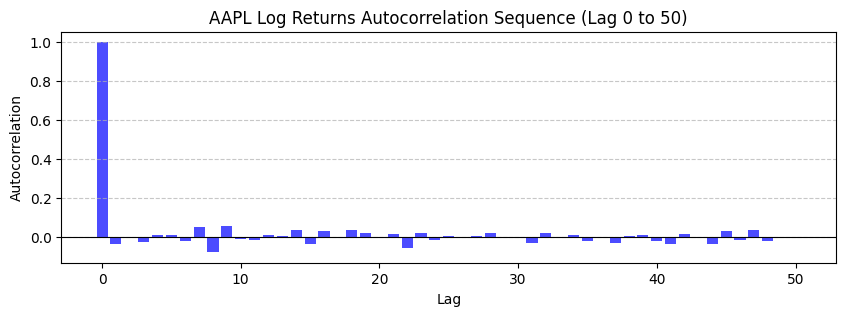

In [10]:
# Function to compute autocorrelation sequence
def autocorr_numpy(x, lags):
    x = x - np.mean(x)  # Demean the series
    result = np.correlate(x, x, mode='full')  # Compute full autocorrelation
    result = result[result.size // 2:]  # Take the second half (positive lags)
    return result[:lags + 1] / result[0]  # Normalize by lag 0 value

# Compute ACS from lag 0 to 50
lags = 50
acs = autocorr_numpy(log_returns, lags)

# Plot ACS
plt.figure(figsize=(10, 3))
plt.bar(range(lags + 1), acs, width=0.8, color="blue", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("AAPL Log Returns Autocorrelation Sequence (Lag 0 to 50)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

We can see that indeed, the autocorr of AAPL is 1 at lag0, then quickly converges to 0 with bigger lags.

### SF3 Clustered volatility

We now study the autocorrelation of the absolute value of $r_t$. The idea is that while $r_t$ should be uncorrelated with $r_{t-1}$, the absolute return $|r_t|$ should be correlated with $|r_{t-1}|$. This is known as volatility clustering. As if the stock moves a lot yesterday, it is more likely to move a lot today, but we don't know the direction.

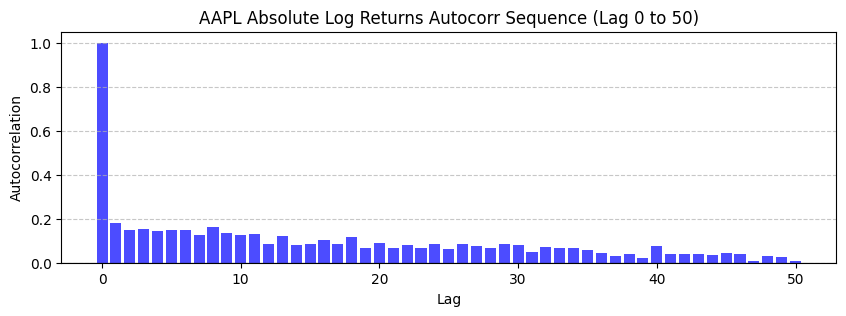

In [11]:
# plot absolute return
abs_returns = np.abs(log_returns)
acs = autocorr_numpy(abs_returns, lags)

# Plot ACS
plt.figure(figsize=(10, 3))
plt.bar(range(lags + 1), acs, width=0.8, color="blue", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("AAPL Absolute Log Returns Autocorr Sequence (Lag 0 to 50)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [12]:
def plot_log_returns(returns, title, filename=None):
    returns = returns.dropna()
    # compare with normal of zero mean and same std
    x = np.linspace(returns.min(), returns.max(), 1000)
    y = norm.pdf(x, 0, returns.var()**0.5)          
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, color='black', linestyle='dashed', label='Standard Normal')
    returns.plot.kde(color='red', linewidth=2, label='KDE Plot')
    plt.hist(returns, bins=50, color='blue', alpha=0.3, density=True, label='Histogram')
    plt.title(title)
    plt.xlabel('Log Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


### SF4 Aggregational Normality

We examine whether as the time scale increases (e.g., moving from daily to monthly returns), the distribution of returns becomes more Gaussian due to the Central Limit Theorem.

In particular, we study the weekly returns and monthly returns here.

In [13]:
# define helper function to plot log returns
def plot_log_returns(returns, title):
    returns = returns.dropna()
    # compare with normal of zero mean and same std
    x = np.linspace(returns.min(), returns.max(), 1000)
    y = norm.pdf(x, 0, returns.var()**0.5)          
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, color='black', linestyle='dashed', label='Standard Normal')
    returns.plot.kde(color='red', linewidth=2, label='KDE Plot')
    plt.hist(returns, bins=50, color='blue', alpha=0.3, density=True, label='Histogram')
    plt.title(title)
    plt.xlabel('Log Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

Week_returns = apple_data['log_returns'].iloc[1:].resample('W').sum() * 100
Month_returns = apple_data['log_returns'].iloc[1:].resample('M').sum() * 100

/var/folders/fd/vr4zygtx6jxftqb9dm5hvstw0000gn/T/ipykernel_26397/1113565319.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Month_returns = apple_data['log_returns'].iloc[1:].resample('M').sum() * 100


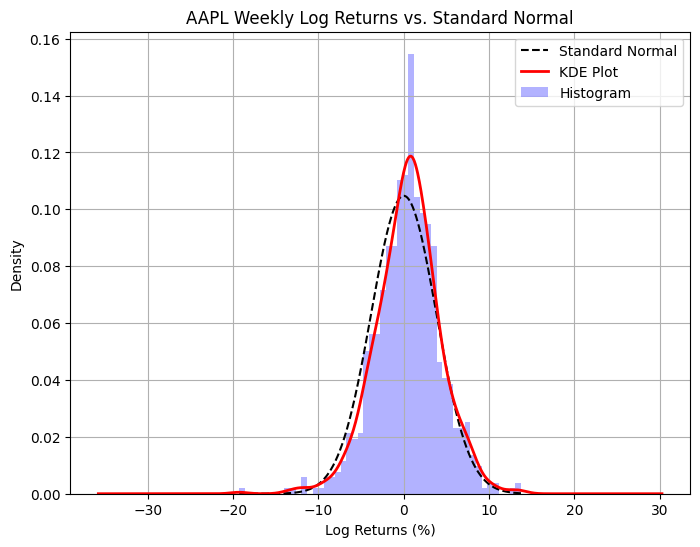

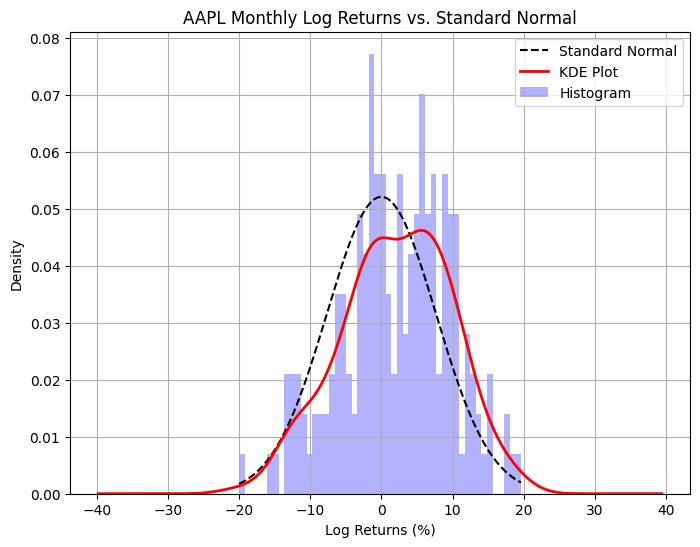

In [14]:
plot_log_returns(Week_returns, "AAPL Weekly Log Returns vs. Standard Normal")
plot_log_returns(Month_returns, "AAPL Monthly Log Returns vs. Standard Normal")

We can see that this is indeed closer to normality than the daily returns.